In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, FunctionTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier



In [3]:
df = pd.read_csv('../data/df_train.csv')
df_test = pd.read_csv('../data/df_test.csv')
df['ShapeFactor5'] = df['MajorAxisLength'] / df['Perimeter']
df_test['ShapeFactor5'] = df_test['MajorAxisLength'] / df_test['Perimeter']

In [27]:
X = df.drop(columns=['Class'])
y = df['Class']

# Feature selection

In [28]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [feature for feature in df.columns if feature != 'Class']
forest = RandomForestClassifier(random_state=311)
forest.fit(X, y)

RandomForestClassifier(random_state=311)

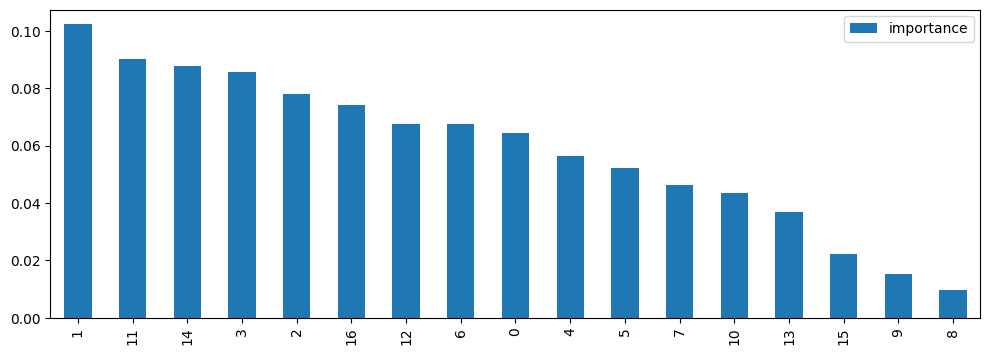

In [36]:
# TODO tu się coś minimalnie zjebało

importances = forest.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(12, 4))
feature_importances.sort_values('importance', ascending=False).plot.bar(ax=ax)
importance_threshold = feature_importances.max()


Wynika z tego, że możemy nie brać pod uwagę niektórych kolumn, ale musimy sprawdzić jeszcze, jak dużo z nich usunąć

In [37]:
def evaluate_feature_importance(X, y, importance_threshold):
    forest = RandomForestClassifier(random_state=311)
    forest.fit(X, y)
    importances = forest.feature_importances_

    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
    feature_importances = feature_importances.sort_values('importance', ascending=True)

    clf = RandomForestClassifier(random_state=311)
    clf.fit(X, y)

    results = []

    for i in range(len(feature_importances)):
        selected_features = feature_importances['feature'].iloc[i:]

        if feature_importances['importance'].iloc[i] > importance_threshold:
            break

        pipeline = Pipeline(steps=[
            ('classifier', clf)
        ])

        scores = cross_val_score(pipeline, X[selected_features], y, cv=5, scoring='accuracy')

        results.append({
            'num_features': len(selected_features),
            'accuracy': scores.mean(),
            'std': scores.std()
        })

    return pd.DataFrame(results)

In [38]:
results_with_1 = evaluate_feature_importance(X, y, importance_threshold)
results_with_2 = evaluate_feature_importance(X, y, importance_threshold-0.0001)

TypeError: '>' not supported between instances of 'numpy.ndarray' and 'str'

<Axes: xlabel='num_features'>

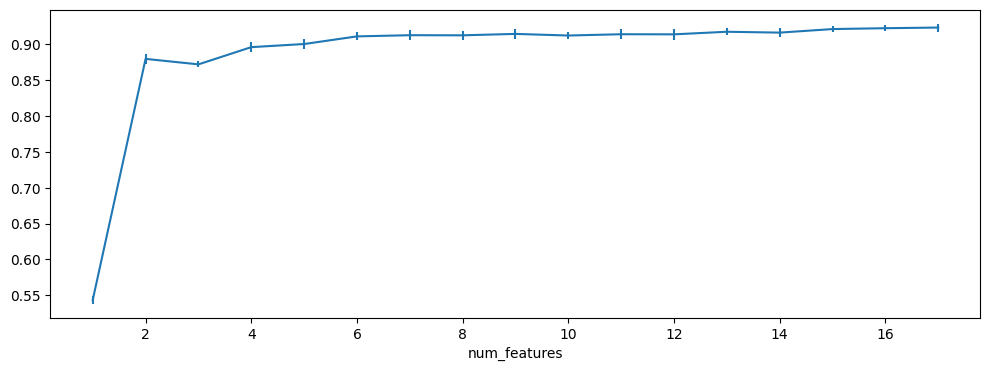

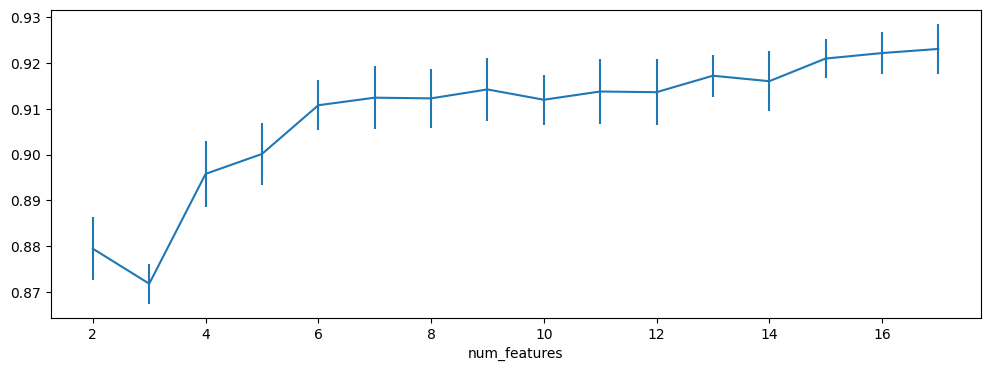

In [ ]:
results_with_1.plot(x='num_features', y='accuracy', yerr='std', figsize=(12, 4), legend=False)
results_with_2.plot(x='num_features', y='accuracy', yerr='std', figsize=(12, 4), legend=False)

In [39]:
print(feature_importances.iloc[:]['feature'])

8              Extent
9            Solidity
15       ShapeFactor4
13       ShapeFactor2
10          roundness
7       EquivDiameter
5        Eccentricity
4        AspectRation
0                Area
6          ConvexArea
12       ShapeFactor1
16       ShapeFactor5
2     MajorAxisLength
3     MinorAxisLength
14       ShapeFactor3
11        Compactness
1           Perimeter
Name: feature, dtype: object


Z wykresów wynika, że powinniśmy na pewno usunąć kolumny ShapeFactor2, AspectRatio i ShapeFactor3

Do tego możemy wziąć również pod uwagę kolumny których usuwanie podczas wykonania funkcji *evaluate_feature_importance* nie zmienia znacznie parametru accuracy modelu

In [ ]:
features_to_drop1 = ['ShapeFactor2', 'AspectRation', 'ShapeFactor3']
features_to_drop2 = ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1']
features_to_drop3 = ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1', 'Extent', 'Solidity', 'ShapeFactor2']
mask1 = feature_importances['feature'].isin(features_to_drop1)
mask2 = feature_importances['feature'].isin(features_to_drop2)
mask3 = feature_importances['feature'].isin(features_to_drop3)
feature_names1 = feature_importances[~mask1]['feature']
feature_names2 = feature_importances[~mask2]['feature']
feature_names3 = feature_importances[~mask3]['feature']

clf = RandomForestClassifier(random_state=311)

pipeline = Pipeline(steps=[
            ('classifier', clf)
        ])

scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
scores1 = cross_val_score(pipeline, X[feature_names1], y, cv=7, scoring='accuracy')
scores2 = cross_val_score(pipeline, X[feature_names2], y, cv=7, scoring='accuracy')
scores3 = cross_val_score(pipeline, X[feature_names3], y, cv=7, scoring='accuracy')

print("Scores\t\tMean\t\tStd")
print("-----\t\t----\t\t---")
print("scores\t\t{0}\t\t{1}".format(round(scores.mean(), 5), round(scores.std(), 5)))
print("scores1\t\t{0}\t\t{1}".format(round(scores1.mean(), 5), round(scores1.std(), 5)))
print("scores2\t\t{0}\t\t{1}".format(round(scores2.mean(), 5), round(scores2.std(), 5)))
print("scores3\t\t{0}\t\t{1}".format(round(scores3.mean(), 5), round(scores3.std(), 5)))


Scores		Mean		Std
-----		----		---
scores		0.92262		0.00485
scores1		0.92397		0.00318
scores2		0.92502		0.00631
scores3		0.91887		0.00804


Okazuje się że możemy usunąć bardzo dużo kolumn bez znacznej utraty accuracy lub usunąć pojedyncze kolumny co daje większą wartość accuracy niż wyjściowe dane. W dalszej części projektu będziemy starali się ustalić które podejście będzie najbardziej efektywne

# Tworzenie Pipeline'ów

In [14]:
def drop_columns(X, columns_to_drop):
    return X.drop(columns=columns_to_drop, axis=1)

In [16]:
# To na razie jeszcze nie działa ale ma potencjał

def test_models_with_dropped_columns(X, y, models, columns_to_drop):
    """
    Test multiple models with different sets of dropped columns.

    Parameters:
    X (DataFrame): The input data
    y (Series or array-like): The target values
    models (list): A list of tuples, where each tuple contains a string (the model name) and a scikit-learn estimator object (the model)
    columns_to_drop (list): A list of lists, where each inner list contains the names of the columns to be dropped

    Returns:
    DataFrame: A DataFrame containing the mean and standard deviation of the accuracy for each combination of model and dropped columns
    """
    results = []
    for model_name, model in models:
        for columns in columns_to_drop:
            drop_columns_transformer = FunctionTransformer(drop_columns, kw_args={'columns_to_drop': columns})

            preprocessor = ColumnTransformer(
                transformers=[
                    ('drop_columns', drop_columns_transformer, columns)
                ])
            
            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', model)
            ])

            scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
            results.append({
                'model' : model_name,
                'columns_dropped' : columns,
                'mean_accuracy' : scores.mean(),
                'std_accuracy' : scores.std()
            })

    return pd.DataFrame(results)

In [26]:
# to do wyjebania jeśli funkcja zadziała

drop_columns_transformer1 = FunctionTransformer(drop_columns, kw_args={'columns_to_drop': features_to_drop1})
drop_columns_transformer2 = FunctionTransformer(drop_columns, kw_args={'columns_to_drop': features_to_drop2})
drop_columns_transformer3 = FunctionTransformer(drop_columns, kw_args={'columns_to_drop': features_to_drop3})

preprocessor1 = ColumnTransformer(
    transformers=[
        ('drop1', drop_columns_transformer1, feature_names1),
    ])

preprocessor2 = ColumnTransformer(
    transformers=[
        ('drop2', drop_columns_transformer2, feature_names2),
    ])

preprocessor3 = ColumnTransformer(
    transformers=[
        ('drop3', drop_columns_transformer3, feature_names3),
    ])



NameError: name 'features_to_drop1' is not defined

In [25]:
# to test tylko bo coś funkcja nie działa na razie 

pipe = Pipeline(steps=[
    ('preprocessor1', preprocessor1),
    ('svc', SVC())
])

score = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')

NameError: name 'preprocessor1' is not defined

In [ ]:
# potestujemy sobie teraz te wybrane kolumny razem ze skalowaniem i bez na gołych modelach: SVC, XGBoost, RandomForest, AdaBoost, LGBM

### Utworzenie wstępnych modeli do testowania wyborów kolumn oraz ich skalowania

In [17]:
models = [('SVC', SVC(random_state=311)), 
          ('XGBoost', XGBClassifier(random_state=311)), 
          ('RandomForest', RandomForestClassifier(random_state=311)), 
          ('AdaBoost', AdaBoostClassifier(random_state=311)), 
          ('LGBM', LGBMClassifier(random_state=311))]

columns_to_drop = [
    ['ShapeFactor2', 'AspectRation', 'ShapeFactor3'],
    ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1'],
    ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1', 'Extent', 'Solidity', 'ShapeFactor2']
]

In [24]:
results = test_models_with_dropped_columns(X, y, models, columns_to_drop)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    X, y = self._validate_data(
  File "c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
  File "c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py", line 1081, in check_array
    raise ValueError(
ValueError: Found array with 0 feature(s) (shape=(5334, 0)) while a minimum of 1 is required by SVC.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    X, y = self._validate_data(
  File "c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
  File "c:\Users\Tomek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py", line 1081, in check_array
    raise ValueError(
ValueError: Found array with 0 feature(s) (shape=(5335, 0)) while a minimum of 1 is required by SVC.


In [23]:
X.columns

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'ShapeFactor5'],
      dtype='object')